In [1]:

import pandas as pd
from pandas import read_excel

#Loeme sisse andmestikud
Netopalgad = pd.read_excel("C:\\Projekt\\Netopalgad.xlsx")
Rahvastik = pd.read_excel("C:\\Projekt\\RahvastikTartuTallinn.xlsx")
TudengidTallinn = pd.read_excel("C:\\Projekt\\Tallinnayliopilased.xlsx")
TudengidTartu = pd.read_excel("C:\\Projekt\\Tartuyliopilased.xlsx")


print(Rahvastik)


   Unnamed: 0    2006    2007    2008    2009    2010    2011    2012    2013  \
0        Linn   Kokku   Kokku   Kokku   Kokku   Kokku   Kokku   Kokku   Kokku   
1     Tallinn  397575  396785  397100  397950  399810  402491  404960  408561   
2  Tartu linn  102205  101585  101245  100965  100800  100114   99538   98984   

     2014  ...    2016    2017    2018    2019    2020    2021    2022  \
0   Kokku  ...   Kokku   Kokku   Kokku   Kokku   Kokku   Kokku   Kokku   
1  412423  ...  424979  426538  430805  434562  437619  438341  437811   
2   97891  ...   93406   95677   96506   96974   96123   95430   98312   

     2023    2024    2025  
0   Kokku   Kokku   Kokku  
1  453864  457572  456518  
2  100724  101032  100685  

[3 rows x 21 columns]


C:\Users\raimo\PycharmProjects\PythonProject\.venv\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\raimo\PycharmProjects\PythonProject\.venv\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Tallinn r = 0.8930240022192987
Tallinn p = 1.1749746992498533e-07
Tartu r = -0.11576401140221915
Tartu p = 0.6269552996870229


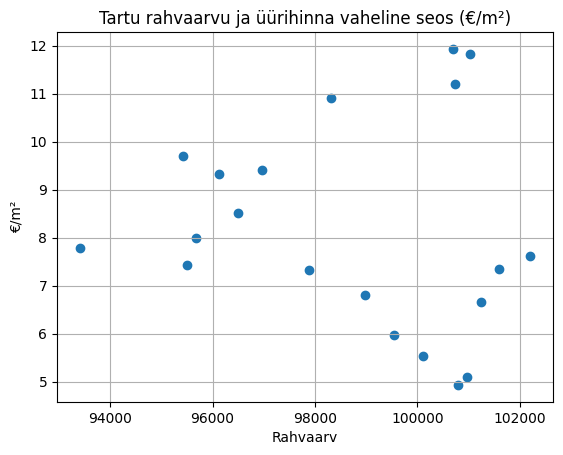

C:\Users\raimo\PycharmProjects\PythonProject


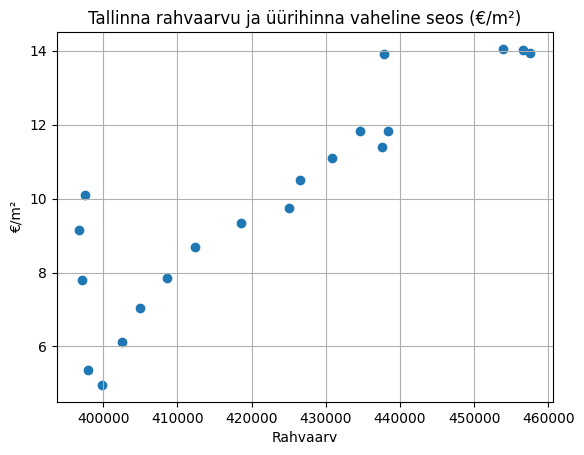

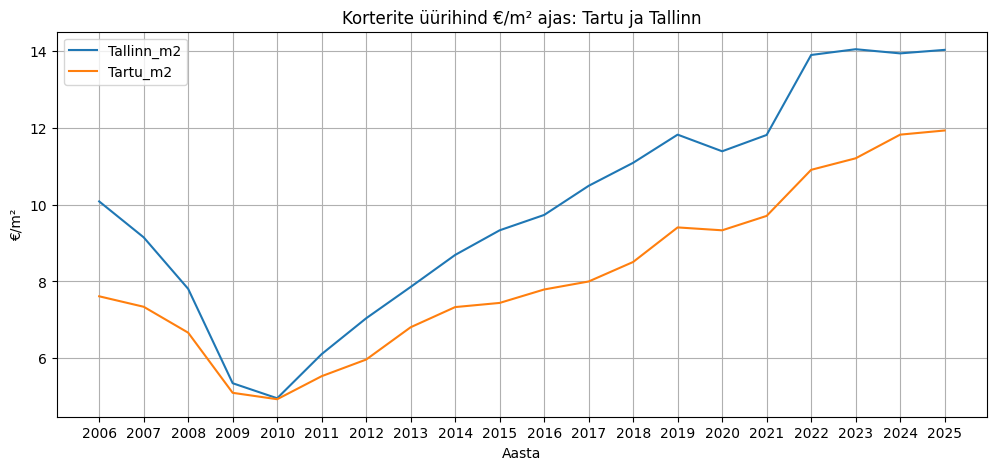

In [41]:

import fitz
import pandas as pd
import re
#Kas rahvaarv on seotud üürihinnaga?
#----------------------------------#
#Puhastame andmestiku
Rahvas = Rahvastik.iloc[1:3]

Rahvastik_pikk = Rahvas.melt(
    id_vars="Unnamed: 0",var_name="Aasta",value_name="Rahvastik"
)

pdf = fitz.open(r"C:\Projekt\Hinnastatistika.pdf")

# võta ainult tabelilehed (2..8) ehk index 1..7
tekst = ""
for page in pdf[1:]:
    tekst += page.get_text("text") + "\n"

tokens = tekst.split()

rows = []
i = 0

date_re = re.compile(r"^(0[1-9]|1[0-2])\.\d{4}$")   # 06.2006 jne
num_re  = re.compile(r"^[\d.,]+$")                 # 7.2 / 1,2 jne

while i < len(tokens):
    if date_re.match(tokens[i]):
        # ootame 6 numbrit järele (Tallinn: hind, kuulutusi, aktiivseid; Tartu: hind, kuulutusi, aktiivseid)
        if i + 6 < len(tokens) and all(num_re.match(t) for t in tokens[i+1:i+7]):
            date = tokens[i]
            tallinn = float(tokens[i+1].replace(",", "."))
            tartu   = float(tokens[i+4].replace(",", "."))  # Tartu Hind(m2)

            rows.append([date, tallinn, tartu])
            i += 7
            continue
    i += 1

rent_df = pd.DataFrame(rows, columns=["Kuupäev", "Tallinn_m2", "Tartu_m2"])
#Teeme datetime-ks kuupäeva
rent_df["Kuupäev"] = pd.to_datetime(
    rent_df["Kuupäev"],
    format="%m.%Y"
)
rent_df["Aasta"] = rent_df["Kuupäev"].dt.year

aastakeskmine = (
    rent_df
    .groupby("Aasta")[["Tallinn_m2", "Tartu_m2"]]
    .mean()
)

#Nimetame UNNAMED:0 ümber rahvastik_pikk

rahv = Rahvastik_pikk.rename(columns={"Unnamed: 0": "Linn"})

#Teeme eraldi tartu ja tallinna andmestikud

rahv_tln = rahv[rahv["Linn"] == "Tallinn"]
rahv_trt = rahv[rahv["Linn"] == "Tartu linn"]
#Ühendame need keskmiste üürihindadega (rm kohta)
tln = aastakeskmine.merge(rahv_tln, on="Aasta")
trt = aastakeskmine.merge(rahv_trt, on="Aasta")
#Leiame korrelatsiooni
from scipy.stats import pearsonr
#Teeme arvuliseks, enne korrelatsioon ei töödanud...
x = pd.to_numeric(tln["Rahvastik"])
y = pd.to_numeric(tln["Tallinn_m2"])

r_tln, p_tln = pearsonr(x, y)
x2 = pd.to_numeric(trt["Rahvastik"])
y2 = pd.to_numeric(trt["Tartu_m2"])

r_trt, p_trt = pearsonr(x2, y2)

print("Tallinn r =", r_tln)
print("Tallinn p =", p_tln)
print("Tartu r =", r_trt)
print("Tartu p =", p_trt)

#Tartu puhul ei ole korrelatsioon statistiliselt oluline
#Tallinna puhul on väga tugev positiivne korrelatsioon, ning see on ka statistiliselt oluline 95% usaldusnivool

#Graafik
import matplotlib.pyplot as plt
plt.scatter(trt["Rahvastik"], trt["Tartu_m2"])
plt.xlabel("Rahvaarv")
plt.ylabel("€/m²")
plt.title("Tartu rahvaarvu ja üürihinna vaheline seos (€/m²)")
plt.grid(True)
plt.savefig("TartuRahvaarvUurihind.png", dpi=300, bbox_inches="tight")
plt.show()

import os
print(os.getcwd())

plt.scatter(tln["Rahvastik"], tln["Tallinn_m2"])
plt.xlabel("Rahvaarv")
plt.ylabel("€/m²")
plt.title("Tallinna rahvaarvu ja üürihinna vaheline seos (€/m²)")
plt.grid(True)
plt.savefig("TalinnRahvaarvUurihind.png", dpi=300, bbox_inches="tight")
plt.show()

aastakeskmine.plot(figsize=(12,5))
plt.ylabel("€/m²")
plt.title("Korterite üürihind €/m² ajas: Tartu ja Tallinn")
plt.grid(True)
plt.xticks(aastakeskmine.index)
plt.savefig("MuutusAjasUurihind.png", dpi=300, bbox_inches="tight")
plt.show()



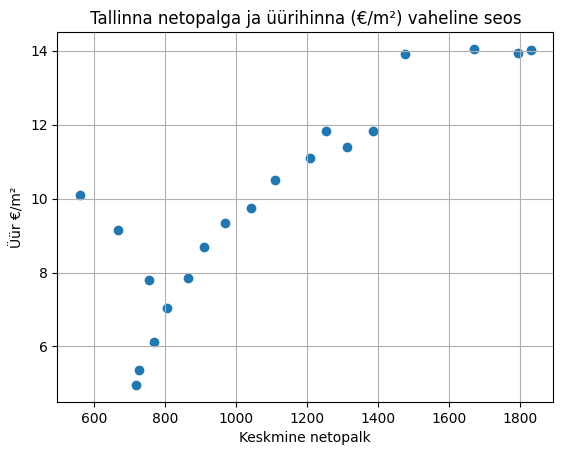

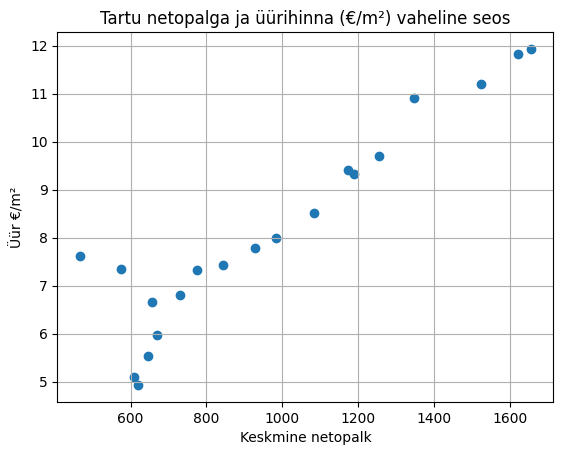

Tallinn r = 0.8741155770053066
Tallinn p = 4.732972326983216e-07
Tartu r = 0.9331158975375237
Tartu p = 1.992479609613243e-09
------------------------------------------------
Tallinna regressioonimudel
tõus (slope) = 0.006511172917727835
vabaliige = 2.826416033231668
r = 0.8741155770053064
p = 4.732972326983294e-07
Rsquare 0.7640780419633197
------------------------------------------------
Tartu regressioonimudel
tõus (slope) = 0.005430682153026166
vabaliige = 2.9115854956926093
r = 0.9331158975375238
p = 1.9924796096132362e-09
Rsquare 0.8707052782372585
-------------------------------------------------


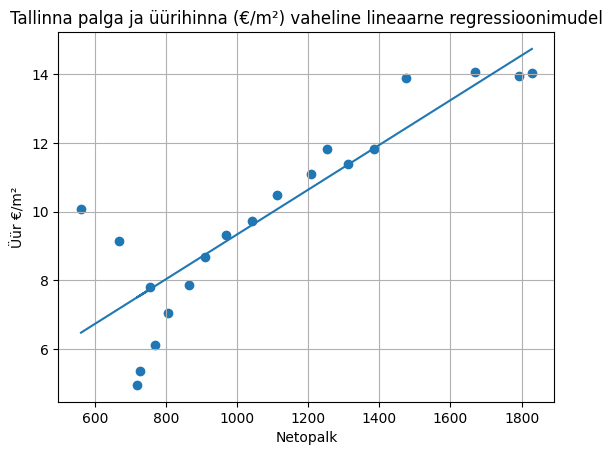

-------------------------------------------------


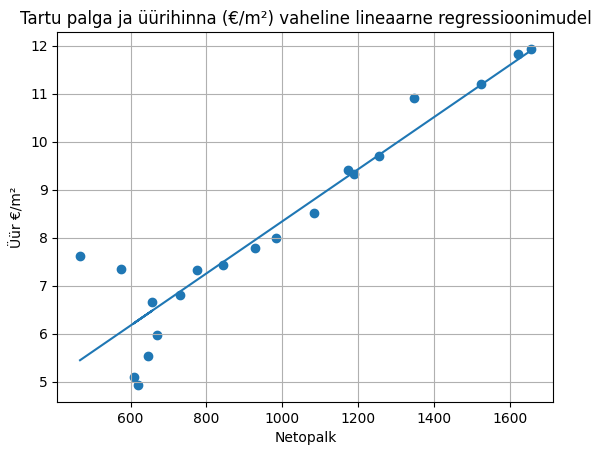

In [42]:
#Kas kõrgem palk tähendab kõrgemat üüri?
palgad_pikk = Netopalgad.melt(
    id_vars="Linn", var_name="Aasta", value_name="Netopalk"
)
#Teeme väärtused arvuks
palgad_pikk["Aasta"] = palgad_pikk["Aasta"].astype(int)

#Eraldi Tartu ja Tallinn
palk_tln = palgad_pikk[palgad_pikk["Linn"] == "Tallinn"]
palk_trt = palgad_pikk[palgad_pikk["Linn"] == "Tartu"]

#Ühendame üürihindadega
tln_palkjayyr = aastakeskmine.merge(palk_tln, on="Aasta")
trt_palkjayyr = aastakeskmine.merge(palk_trt, on="Aasta")

import matplotlib.pyplot as plt
#Tallinna oma
plt.scatter(
    tln_palkjayyr["Netopalk"],
    tln_palkjayyr["Tallinn_m2"]
)

plt.xlabel("Keskmine netopalk")
plt.ylabel("Üür €/m²")
plt.title("Tallinna netopalga ja üürihinna (€/m²) vaheline seos")

plt.grid(True)
plt.savefig("TallinNetoVsUurihind.png",dpi=300, bbox_inches="tight")

plt.show()
#Tartu oma
plt.scatter(
    trt_palkjayyr["Netopalk"],
    trt_palkjayyr["Tartu_m2"]
)
plt.xlabel("Keskmine netopalk")
plt.ylabel("Üür €/m²")
plt.title("Tartu netopalga ja üürihinna (€/m²) vaheline seos")
plt.grid(True)
plt.savefig("TartuNetoVsUurihind.png",dpi=300, bbox_inches="tight")
plt.show()

#Korrelatsioonid
from scipy.stats import pearsonr

r, p = pearsonr(
    tln_palkjayyr["Netopalk"],
    tln_palkjayyr["Tallinn_m2"]
)

print("Tallinn r =", r)
print("Tallinn p =", p)

r2, p2 = pearsonr(
    trt_palkjayyr["Netopalk"],
    trt_palkjayyr["Tartu_m2"]
)
print("Tartu r =", r2)
print("Tartu p =", p2)
#Mõlemal tugevad positiivsed korrelatsioonid, ning statistiliselt olulsied 95% usaldusnivool
print("------------------------------------------------")
print("Tallinna regressioonimudel")
#Teeme ka regressioonmudeli
from scipy.stats import linregress

tulemus = linregress(
    tln_palkjayyr["Netopalk"],
    tln_palkjayyr["Tallinn_m2"]
)

print("tõus (slope) =", tulemus.slope)
print("vabaliige =", tulemus.intercept)
print("r =", tulemus.rvalue)
print("p =", tulemus.pvalue)
print("Rsquare", tulemus.rvalue**2)
print("------------------------------------------------")
print("Tartu regressioonimudel")
tulemus2 = linregress(
    trt_palkjayyr["Netopalk"],
    trt_palkjayyr["Tartu_m2"]
)

print("tõus (slope) =", tulemus2.slope)
print("vabaliige =", tulemus2.intercept)
print("r =", tulemus2.rvalue)
print("p =", tulemus2.pvalue)
print("Rsquare",tulemus2.rvalue**2)
print("-------------------------------------------------")

x = tln_palkjayyr["Netopalk"]
y = tulemus.intercept + tulemus.slope * x

plt.scatter(x, tln_palkjayyr["Tallinn_m2"])
plt.plot(x, y)

plt.xlabel("Netopalk")
plt.ylabel("Üür €/m²")
plt.title("Tallinna palga ja üürihinna (€/m²) vaheline lineaarne regressioonimudel")
plt.grid(True)
plt.savefig("TallinnMudelPalkUUR.png",dpi=300, bbox_inches="tight")
plt.show()

print("-------------------------------------------------")

x2 = trt_palkjayyr["Netopalk"]
y2 = tulemus2.intercept + tulemus2.slope * x2

plt.scatter(x2, trt_palkjayyr["Tartu_m2"])
plt.plot(x2, y2)

plt.xlabel("Netopalk")
plt.ylabel("Üür €/m²")
plt.title("Tartu palga ja üürihinna (€/m²) vaheline lineaarne regressioonimudel")
plt.grid(True)
plt.savefig("TartuMudelPalkUUR.png",dpi=300, bbox_inches="tight")
plt.show()


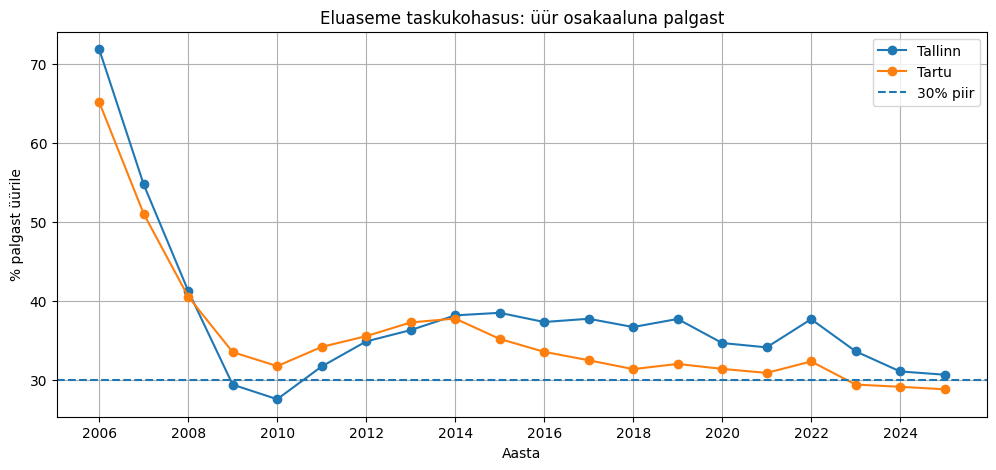

Paardatud t-test: Tallinn vs Tartu
t-statistik: 2.9180951952898235
p-väärtus: 0.008820639646471375


In [45]:
#Kuidas erineb eluaseme taskukohasus Tartu ja Tallinna vahel
#Selles peatükis valime umbes 1-toalise üürikorteri või väikse kahetoalise
#40-50rm
tln_palkjayyr["Uur_kuus"] = tln_palkjayyr["Tallinn_m2"] * 40
tln_palkjayyr["Palgast_uurile_%"] = (
    tln_palkjayyr["Uur_kuus"] / tln_palkjayyr["Netopalk"]
) * 100

trt_palkjayyr["Uur_kuus"] = trt_palkjayyr["Tartu_m2"] * 40
trt_palkjayyr["Palgast_uurile_%"] = (
    trt_palkjayyr["Uur_kuus"] / trt_palkjayyr["Netopalk"]
) * 100

plt.figure(figsize=(12,5))

plt.plot(tln_palkjayyr["Aasta"], tln_palkjayyr["Palgast_uurile_%"],
         label="Tallinn", marker="o")

plt.plot(trt_palkjayyr["Aasta"], trt_palkjayyr["Palgast_uurile_%"],
         label="Tartu", marker="o")

plt.axhline(30, linestyle="--", label="30% piir")

plt.title("Eluaseme taskukohasus: üür osakaaluna palgast")
plt.xlabel("Aasta")
plt.ylabel("% palgast üürile")

plt.legend()
plt.grid(True)
plt.xticks(tln_palkjayyr["Aasta"][::2])
plt.savefig("EluasemeTaskukohasus.png",dpi=300, bbox_inches="tight")
plt.show()
#Graafik näitab, et 2000. aastate keskpaigas moodustas üür üksikisiku netopalgast väga suure osa, ulatudes Tallinnas üle 70% ja Tartus üle 60%. Pärast finantskriisi paranes taskukohasus märgatavalt ning stabiliseerus järgnevatel aastatel umbes 30–40% tasemel. Kuigi Tallinnas on üürikulude osakaal järjepidevalt kõrgem kui Tartus, on viimastel aastatel mõlemas linnas toimunud teatav paranemine.

#Teeme T-testi, et selgitada välja kas Tartu ja Tallinna eluaseme taskukohasus on statistiliselt erinev
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(
    tln_palkjayyr["Palgast_uurile_%"],
    trt_palkjayyr["Palgast_uurile_%"]
)

print("Paardatud t-test: Tallinn vs Tartu")
print("t-statistik:", t_stat)
print("p-väärtus:", p_val)


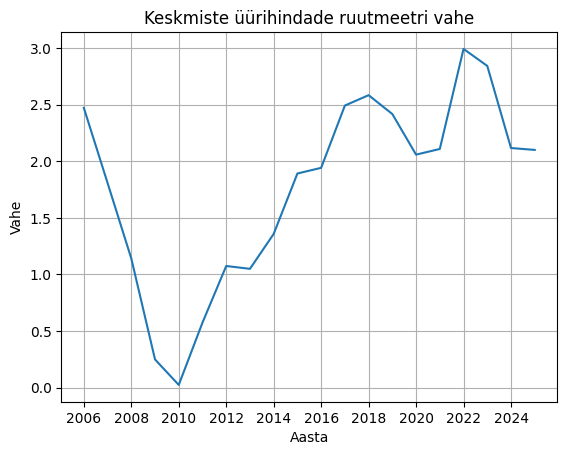

Slope: 0.08729412817758682
P-väärtus: 0.004176117213912115


In [46]:
#Kas linnade üürihindade keskmine vahe ajas väheneb või suureneb?
import matplotlib.pyplot as plt
aastakeskmine["Vahe"] = aastakeskmine["Tallinn_m2"] - aastakeskmine["Tartu_m2"]
plt.plot(aastakeskmine.index, aastakeskmine["Vahe"])
plt.xticks(aastakeskmine.index[::2])
plt.title("Keskmiste üürihindade ruutmeetri vahe")
plt.xlabel("Aasta")
plt.ylabel("Vahe")
plt.grid(True)
plt.savefig("KeskmisteuurihindadeRMVAHE.png",dpi=300, bbox_inches="tight")
plt.show()

from scipy.stats import linregress

x = aastakeskmine.index  # aastad
y = aastakeskmine["Vahe"]

res = linregress(x, y)

print("Slope:", res.slope)
print("P-väärtus:", res.pvalue)



Korrelatsioon Tartus:  -0.6109848035424049
P-väärtus:  0.0042122322257047646


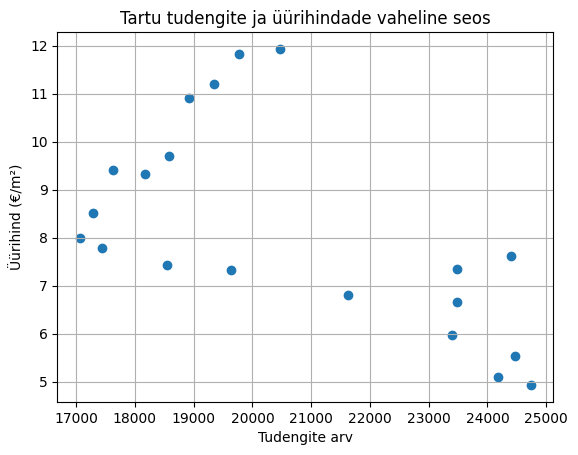

Korrelatsioon Tallinn:  -0.8624103104425422
P-väärtus:  1.0076268795584684e-06


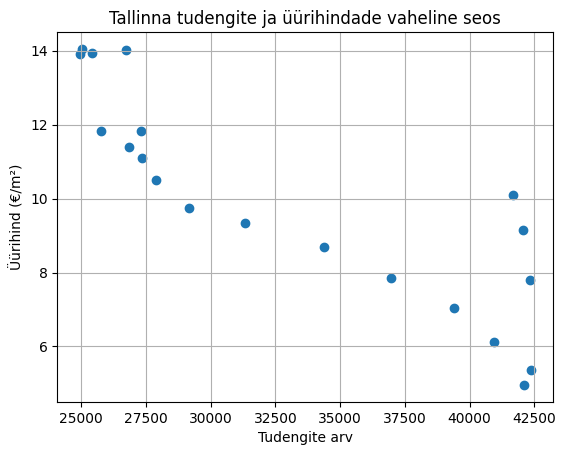

In [33]:
#Kas tudengite ja üürihindade vahel on seos
#Tallinn
TudengidTallinn[TudengidTallinn['Õppeaasta']=="Total"]
TudengidTartu[TudengidTartu["Õppeaasta"]=="Total"]
TudengTLN_pikk = TudengidTallinn[TudengidTallinn['Õppeaasta']=="Total"].melt(
    id_vars = "Õppeaasta", var_name="Aasta", value_name = "Tudengid_Tallinn"
)
TudengTLN_pikk["Aasta"] = TudengTLN_pikk["Aasta"].str.split("/").str[0].astype(int)
TudengTallinn = aastakeskmine.merge(TudengTLN_pikk, on="Aasta")
#Tartu
TudengTRT_pikk = TudengidTartu[TudengidTartu["Õppeaasta"]=="Total"].melt(
    id_vars="Õppeaasta", var_name="Aasta", value_name = "Tudengid_Tartu"
)
TudengTRT_pikk["Aasta"] = TudengTRT_pikk["Aasta"].str.split("/").str[0].astype(int)
TudengidTartus = aastakeskmine.merge(TudengTRT_pikk, on="Aasta")
#Leiame pearsoni korrelatsiooni ja p-väärtuse
#Tartus
x = pd.to_numeric(TudengidTartus["Tartu_m2"])
y = pd.to_numeric(TudengidTartus["Tudengid_Tartu"])
r,p = pearsonr(x, y)
print("Korrelatsioon Tartus: ",r)
print("P-väärtus: ", p)
#Graafik
plt.scatter(y,x)
plt.xlabel("Tudengite arv")
plt.ylabel("Üürihind (€/m²)")
plt.title("Tartu tudengite ja üürihindade vaheline seos")
plt.grid(True)
plt.savefig("TartuTudengidUurihind.png",dpi=300, bbox_inches="tight")
plt.show()
#Tallinnas
x2 = pd.to_numeric(TudengTallinn["Tallinn_m2"])
y2 = pd.to_numeric(TudengTallinn["Tudengid_Tallinn"])
r2,p2 = pearsonr(x2, y2)
print("Korrelatsioon Tallinn: ", r2)
print("P-väärtus: ", p2)
#Graafik 2
plt.scatter(y2,x2)
plt.xlabel("Tudengite arv")
plt.ylabel("Üürihind (€/m²)")
plt.title("Tallinna tudengite ja üürihindade vaheline seos")
plt.grid(True)
plt.savefig("TallinnTudengidUurihind.png",dpi=300, bbox_inches="tight")
plt.show()


Index(['Linn', 'Aasta', 'Rahvastik'], dtype='object')
Korrelatsioon Tartus:  -0.6829901644242872
P-väärtus:  0.0009036793406643417
---------------------------------------------------
Korrelatsioon Tallinn:  -0.867080114997475
P-väärtus:  7.517467262751662e-07
------------------------------------
Tartu mudel
Slope:  -61.268158887261265
Intercept:  20.95059951626469
R2:  0.4664755647003148
P-väärtus:  0.0009036793406643442


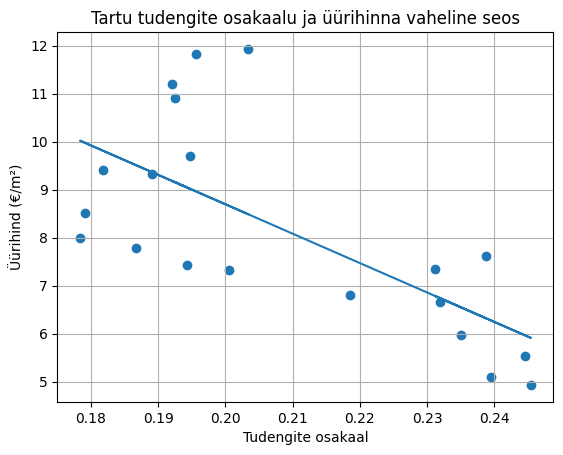

------------------------------------
Tallinna mudel
Slope:  -120.13370807785566
Intercept:  19.44699709995286
R2:  0.7518279258240346
P-väärtus:  7.517467262751625e-07


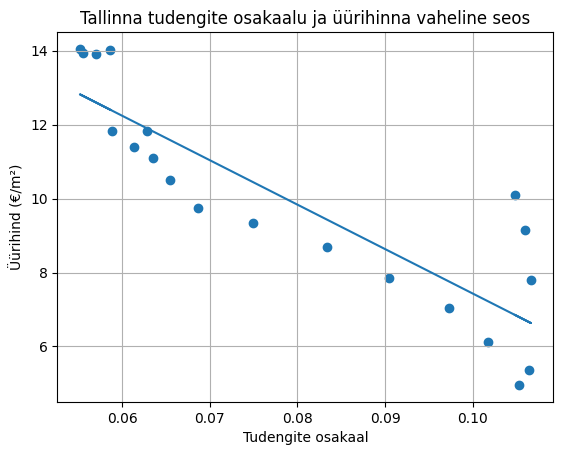

In [35]:
#Kas tudengite osakaal elanikkonnast mõjutab üürihindu?
TudengidTartus
TudengidTallinn
rahv_tln
rahv_trt
#Kas Tartus mõjutab
tartuUhend = TudengidTartus.merge(rahv_trt, on="Aasta")
print(rahv_trt.columns)
tartuUhend["suhe"] = (tartuUhend["Tudengid_Tartu"]/tartuUhend["Rahvastik"])
x=pd.to_numeric(tartuUhend["Tartu_m2"])
y=pd.to_numeric(tartuUhend["suhe"])
r, p = pearsonr(y, x)
print("Korrelatsioon Tartus: ",r)
print("P-väärtus: ", p)
#Kas Tallinnas mõjutab
print("---------------------------------------------------")
tallinnUhend = TudengTLN_pikk.merge(rahv_tln, on="Aasta")
tallinnUhend["suhe"] = (tallinnUhend["Tudengid_Tallinn"] / tallinnUhend["Rahvastik"])
tallinnUhend = aastakeskmine.merge(tallinnUhend, on="Aasta")
x2 = pd.to_numeric(tallinnUhend["Tallinn_m2"])
y2 = pd.to_numeric(tallinnUhend["suhe"])

r2,p2 = pearsonr(y2,x2)
print("Korrelatsioon Tallinn: ", r2)
print("P-väärtus: ", p2)

#Mõlemal oluline negatiivne korrelatsioon.
#Teeme mudeli ka
print("------------------------------------")
print("Tartu mudel")
t = linregress(y,x)
print("Slope: ",t.slope)
print("Intercept: ",t.intercept)
print("R2: ", t.rvalue**2)
print("P-väärtus: ", t.pvalue)
#Graafik

x3 = t.intercept + t.slope * y
plt.scatter(y, x)
plt.plot(y,x3)
plt.title("Tartu tudengite osakaalu ja üürihinna vaheline seos")
plt.xlabel("Tudengite osakaal")
plt.ylabel("Üürihind (€/m²)")
plt.grid(True)
plt.savefig("MudelTartuTOsakaalUurihind.png",dpi=300, bbox_inches="tight")
plt.show()

print("------------------------------------")
print("Tallinna mudel")
t2=linregress(y2,x2)
print("Slope: ",t2.slope)
print("Intercept: ",t2.intercept)
print("R2: ", t2.rvalue**2)
print("P-väärtus: ", t2.pvalue)
#Graafik
x4 = t2.intercept + t2.slope * y2
plt.scatter(y2,x2)
plt.plot(y2,x4)
plt.title("Tallinna tudengite osakaalu ja üürihinna vaheline seos")
plt.xlabel("Tudengite osakaal")
plt.ylabel("Üürihind (€/m²)")
plt.grid(True)
plt.savefig("TallinnaTudengOsakaalMudelUurihind.png",dpi=300, bbox_inches="tight")
plt.show()

Korrelatsioon Tartu:  0.4944503422105065
P-väärtus:  0.026680034573886922
---------------------------------------
Korrelatsioon Tallinn:  0.3183975984077148
P-väärtus:  0.17126421242207623


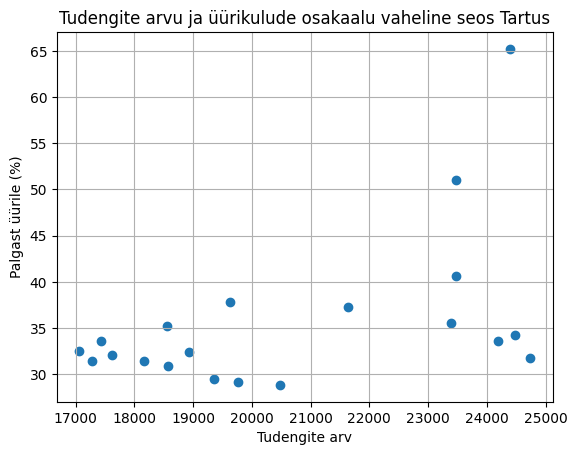

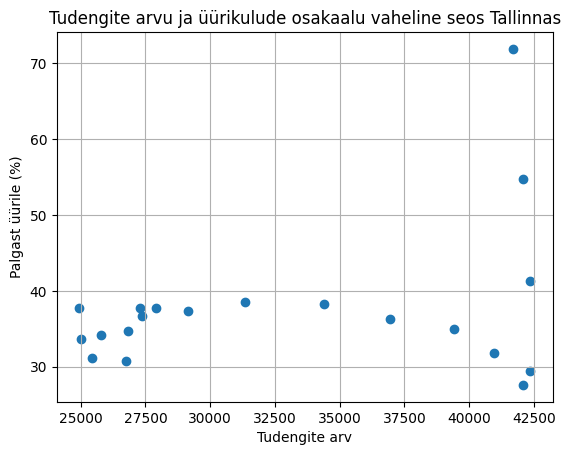

In [39]:
#Kas tudengite arv mõjutab eluaseme taskukohasust
#paneme andmed valmis
tudengTaskuTRT = trt_palkjayyr.merge(TudengidTartus, on="Aasta")
tudengTaskuTLN = tln_palkjayyr.merge(TudengTallinn, on="Aasta")
#Tartu korrelatsioon
x=pd.to_numeric(tudengTaskuTRT["Tudengid_Tartu"])
y=pd.to_numeric(tudengTaskuTRT["Palgast_uurile_%"])

r,p = pearsonr(x,y)
print("Korrelatsioon Tartu: ", r)
print("P-väärtus: ", p)

print("---------------------------------------")
#Tallinn
x2 = pd.to_numeric(tudengTaskuTLN["Tudengid_Tallinn"])
y2 = pd.to_numeric(tudengTaskuTLN["Palgast_uurile_%"])
r2,p2 = pearsonr(x2,y2)
print("Korrelatsioon Tallinn: ", r2)
print("P-väärtus: ", p2)
#Seosed puuduvad

#Graafik tartu
plt.scatter(x, y)

plt.title("Tudengite arvu ja üürikulude osakaalu vaheline seos Tartus")
plt.xlabel("Tudengite arv")
plt.ylabel("Palgast üürile (%)")
plt.grid(True)

plt.savefig("Tartu_Tudengid_Taskukohasus.png",
            dpi=300,
            bbox_inches="tight")

plt.show()

#Graafik Tallinn
plt.scatter(x2, y2)

plt.title("Tudengite arvu ja üürikulude osakaalu vaheline seos Tallinnas")
plt.xlabel("Tudengite arv")
plt.ylabel("Palgast üürile (%)")
plt.grid(True)

plt.savefig("Tallinn_Tudengid_Taskukohasus.png",
            dpi=300,
            bbox_inches="tight")

plt.show()

Korrelatsioon Tartu:  -0.7087494866916445
P-väärtus:  0.0004685666989549747
-----------------------------------
Korrelatsioon Tallinn:  -0.7626705538181441
P-väärtus:  9.22835360802096e-05


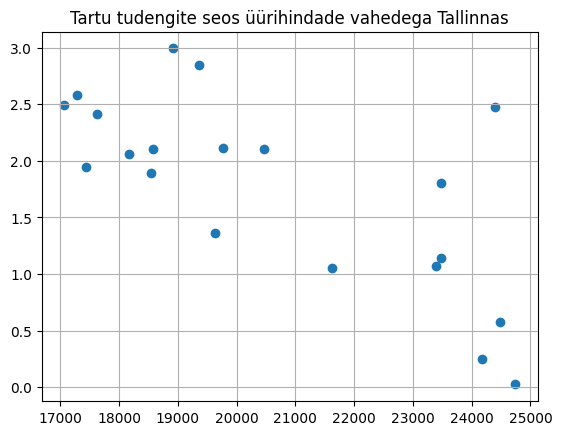

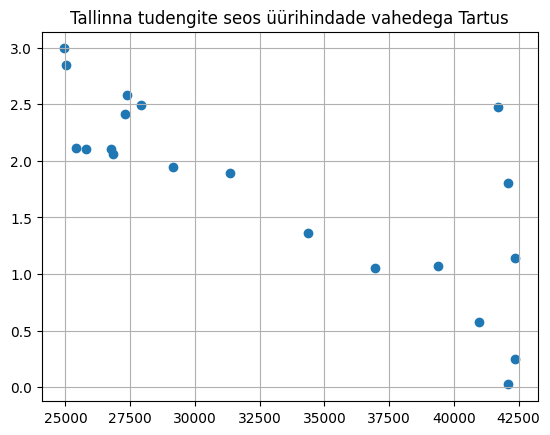

In [12]:
#Kas tudengite arv Tartus on seotud Tallinna ja Tartu üürihindade vahega?
#Tartu
x= pd.to_numeric(tudengTaskuTRT["Tudengid_Tartu"])
y= pd.to_numeric(tudengTaskuTRT["Vahe"])
r,p = pearsonr(x,y)
print("Korrelatsioon Tartu: ", r)
print("P-väärtus: ",p)
#Tallinn
x2=pd.to_numeric(tudengTaskuTLN["Tudengid_Tallinn"])
y2=pd.to_numeric(tudengTaskuTLN["Vahe"])
r2,p2=pearsonr(x2,y2)
#Tallinn
print("-----------------------------------")
print("Korrelatsioon Tallinn: ", r2)
print("P-väärtus: ",p2)
import matplotlib.pyplot as plt
plt.scatter(
    tudengTaskuTRT["Tudengid_Tartu"],
    tudengTaskuTRT["Vahe"]
)
plt.title("Tartu tudengite seos üürihindade vahedega Tallinnas")
plt.grid(True)
plt.savefig("TartuTudengiteSeosUurihndadevahe")
plt.show()

plt.scatter(
    tudengTaskuTLN["Tudengid_Tallinn"],
    tudengTaskuTLN["Vahe"]
)
plt.title("Tallinna tudengite seos üürihindade vahedega Tartus")
plt.grid(True)
plt.show()

